In [34]:
%reload_ext autoreload
%autoreload 2
import autohf as hf
import numpy as np
from matplotlib import pyplot as plt
import time
import autograd

# The Basics of AutoHF

The purpose of this Notebook is to outline some of the basic functionality included in the AutoHF package, as well as explain some of the design choices that were made during the creation of the library.

## A Basic Example

The building blocks of the AutoHF package are atomic oribtals, which are used to produce molecular orbitals during Hartree-Fock. This atomic orbitals often dependent implicitly on sets of parameters. The goal of AutoHF is to make these implicity parameters explicit, when the user desires to differentiate with respect to them. However, it will often be the case that some of these parameters should remain fixed. For this reason, we can always load default parameters corresponding to some molecule and a particular basis set (in this case, we use STO-3G):

In [2]:
M1, M2 = hf.generate_basis_set('sto-3g', ['H', 'H']) # Generates default information for hydrogen

We can then generate all of the corresponding atomic orbitals:

In [3]:
AO = []

# Generates atomic orbitals using the default information
for func in M1:
    L, exp, coeff = func
    AO.append(hf.AtomicBasisFunction(L, C=coeff, A=exp))

# Generates atomic orbitals using the default information
for func in M2:
    L, exp, coeff = func
    AO.append(hf.AtomicBasisFunction(L, C=coeff, A=exp))

Each element of the list `AO` is an `AtomicBasisFunction` object, which can store information such as contraction coefficients, exponents of primitive Gaussians, angular momentum, etc. Any parameter that is not passed into an instance of `AtomicBasisFunction` upon initialization is assumed to be a free parameter with respect to which we can differentiate.

Note that instead of thinking of atomic oribtals as functions of the form $f : \mathbb{R}^{3} \rightarrow \mathbb{R}$, we think about them as maps $\phi : \mathcal{\theta} \rightarrow F$, where $\theta$ is the space of free parameters (these could be coefficients, exponents, nuclear geometry, etc.), and $F$ is the space of all functions of the form of $f$. Thus, we can supply free parameters (in this case, geometry) to an instance of `AtomicBasisFunction`, and get a function $f(x, y, z)$:

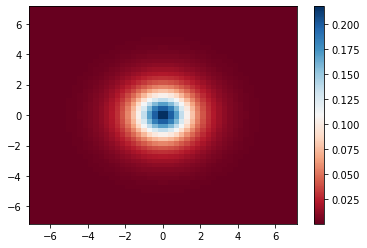

In [21]:
basis_func = AO[0] # Picks a basis function
R = np.array([0.0, 0.0, 0.0]) #Sets coordinates

fn = basis_func(R) # Constructs the basis function

# Plots the basis function for z = 1.0
X, Y = np.meshgrid(np.linspace(-7, 7, 50), np.linspace(-7, 7, 50))
f = lambda x, y : fn([x, y, 1.0])
Z = np.array([f(x, y) for x, y in zip(X, Y)])

plt.pcolormesh(X, Y, Z, shading='auto', cmap='RdBu')
plt.colorbar()
plt.show()

We can also take linear combinations of `AtomicBasisFunction` objects to get `MolecularOrbital` objects. These objects behave similarly to the atomic basis functions. For example:

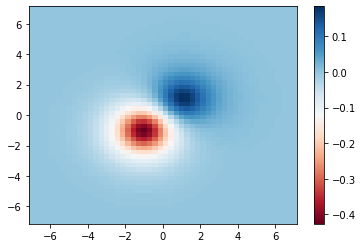

In [25]:
M = hf.MolecularOrbital([-2.0, 1.0], [AO[0], AO[1]]) # Represents the molecular orbital AO[1] - 2 * AO[0]
R1, R2 = np.array([-1.0, -1.0, -1.0]), np.array([1.0, 1.0, 1.0]) # Locations of atomic orbitals

fn = M([R1], [R2]) # Defines the molecular orbital function

# Plots the basis function for z = 0.0
X, Y = np.meshgrid(np.linspace(-7, 7, 50), np.linspace(-7, 7, 50))
f = lambda x, y : fn([x, y, 0.0])
Z = np.array([f(x, y) for x, y in zip(X, Y)])

plt.pcolormesh(X, Y, Z, shading='auto', cmap='RdBu')
plt.colorbar()
plt.show()

We can also use AutoHF to call individual integrals needed for performing Hartree-Fock. Similar to the philosophy behind atomic orbitals as maps from a parameter space, these "integrals" are actually maps of atomic oribtals, to maps from the "free parameter space" to the real numbers. In other words, they are functions that return functions (transforms).

For example, consider the kinetic energy integral:

In [40]:
basis_func_1 = AO[0] # Basis function 1
basis_func_2 = AO[1] # Basis function 2

R1 = np.array([0.0, 0.0, 0.0]) # Location of nucleus 1
R2 = np.array([0.0, 1.0, -1.0]) # Location of nucleus 2

kinetic_integral = hf.generate_kinetic(basis_func_1, basis_func_2) # Generates the overlap integral function

We can then call the integral function for some set of parameters (some geometry, in this case):

In [41]:
kinetic_integral([R1], [R2])

0.23199821854794223

In addition, we can use Autograd to easily take gradients of this integral, with respect to nuclear coordinates. For example, the gradient with respect to $R_1 = (x_1, y_1, z_1)$ is simply given by:

In [42]:
autograd.grad(kinetic_integral, argnum=0)([R1], [R2])

[array([ 0.        ,  0.22046722, -0.22046722])]

Finally, we are able to use AutoHF to perform Hartree-Fock, and generate the one and two electron integrals needed to compute the second-quantized molecular Hamiltonian. Since AutoHF is fully-differentiable, we can also take derivatives of these integrals. Let us first compute the one-electron integral $h_{00}$ for the $H_2$ molecule:

In [49]:
num_elecs = 2 # Number of electrons
idx = [0, 0] # Integral indices
elec_solver = hf.one_electron_integral(num_elecs, AO, idx) # Creates the solver

# Prepares the geometry of the orbitals
R1 = [[np.array([0.0, 0.0, 0.0])] for m in M1] # Location of nucleus 1
R2 = [[np.array([0.5, -1.0, -1.0])] for m in M2] # Location of nucleus 2
R = np.array(R1 + R2)

In [50]:
elec_solver(*R) # Runs the Hartree-Fock solver for one-electron integrals

-1.2214382423120682

As was done above, we may also take derivatives of these integrals:

In [53]:
autograd.grad(elec_solver)(*R)

array([[-0.10245001,  0.20490002,  0.20490002]])

Similar functionality is also supported for the two-electron integrals as well!